#Gravitational Simulator#
###Authors: Siddharth Rau (sidrau2), Vithuran Rathakrishnan (vr27)###
This project is a 3D N-Body Simulator that models and visualizes gravitational interactions between celestial bodies. The system uses numerical methods to simulate the motion of objects under the influence of gravity. The simulation is designed to replicate the behavior of bodies in a gravitational field, such as planets, stars, or asteroids, and provide a 3D visualizations of their trajectories.

A key component of our solar system simulation is the Runge-Kutta 4th Order (RK4) numerical integration method. This technique allows us to approximate the continuous motion of celestial bodies by breaking down their movement into discrete time steps. Unlike other methods, RK4 provides a more accurate representation of gravitational dynamics by:

* Calculating multiple intermediate steps within each time interval
* Accounting for the complex, non-linear nature of gravitational interactions
* Minimizing accumulated numerical errors

Sources:
* Wikipedia was used for the physics, planet data, and RK4 equations
* Python, numpy, and stackoverflow were used as programming references


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib as mpl
from IPython.display import HTML

G = 6.67430e-11
animation.embed_limit = 2**9
mpl.rcParams['animation.embed_limit'] = 2**128
#Helper class
class Body():
    def __init__(self, position, velocity, mass, radius, name="", color='blue'):
        self.position = np.array(position, dtype=float)
        self.velocity = np.array(velocity, dtype=float)
        self.mass = mass
        self.radius = radius
        self.name = name
        self.color = color

    @classmethod
    def from_coords(cls, x, y, z, vx, vy, vz, mass, radius, name="", color='blue'):
        position = np.array([x, y, z], dtype=float)
        velocity = np.array([vx, vy, vz], dtype=float)
        return cls(position, velocity, mass, radius, name, color)

    def print_body(self):
        print(f"{self.name}: Position={self.position}, Velocity={self.velocity}, Mass={self.mass}, Radius={self.radius}")


class Solver():
    def __init__(self, dt: float, body_list=None):
        self.body_list = body_list if body_list else []
        self.dt = dt
        self.positions_history = []

    #Returns the Newtonian gravitational force vector between two objects
    @staticmethod
    def g_force(body1, body2):
        r21 = body2.position - body1.position
        distance = np.sqrt(r21.dot(r21))
        if distance < 1e-6:
            return np.zeros(3)
        return -G * body1.mass * body2.mass / (distance ** 3) * r21

    #Returns a list of gravitational force vectors for each body
    def compute_g_forces(self):
        force_list = [np.zeros(3) for _ in range(len(self.body_list))]
        for i in range(len(self.body_list)):
            for j in range(i + 1, len(self.body_list)):
                force = self.g_force(self.body_list[i], self.body_list[j])
                force_list[i] -= force
                force_list[j] += force
        return force_list

    #Returns if the radii of two objects overlap
    def detect_collisions(self, body1, body2):
        distance = np.linalg.norm(body2.position - body1.position)
        return distance <= (body1.radius + body2.radius)

    #Updates body velocity if a collision is detected
    def elastic_collision(self, body1, body2):
        r = body2.position - body1.position
        if np.dot(r, r) == 0:
          return
        v1 = body1.velocity
        v2 = body2.velocity

        m1 = body1.mass
        m2 = body2.mass

        v1_new = v1 - 2 * m2 / (m1 + m2) * np.dot(v1 - v2, r) / np.dot(r, r) * r
        v2_new = v2 - 2 * m1 / (m1 + m2) * np.dot(v2 - v1, -r) / np.dot(r, r) * (-r)

        body1.velocity = v1_new
        body2.velocity = v2_new

    #Checks collisions during the rk4 solver
    def collisions(self):
        for i in range(len(self.body_list)):
            for j in range(i+1, len(self.body_list)):
                body1 = self.body_list[i]
                body2 = self.body_list[j]

                if self.detect_collisions(body1, body2):
                    self.elastic_collision(body1, body2)

    #Calculates the next state of the system using the runge-kutta 4th order method based on the gravitational and collision forces
    def rk4_step(self, dt):
        initial_positions = [body.position.copy() for body in self.body_list]
        initial_velocities = [body.velocity.copy() for body in self.body_list]
        forces = self.compute_g_forces()

        # k1
        k1_positions = [v * dt for v in initial_velocities]
        k1_velocities = [f / body.mass * dt for f, body in zip(forces, self.body_list)]

        # k2
        k2_positions, k2_velocities = [], []
        for i, body in enumerate(self.body_list):
            temp_pos = initial_positions[i] + 0.5 * k1_positions[i]
            temp_vel = initial_velocities[i] + 0.5 * k1_velocities[i]
            body.position, body.velocity = temp_pos, temp_vel
        forces_k2 = self.compute_g_forces()
        for i, body in enumerate(self.body_list):
            k2_positions.append(body.velocity * dt)
            k2_velocities.append(forces_k2[i] / body.mass * dt)

        # k3
        k3_positions, k3_velocities = [], []
        for i, body in enumerate(self.body_list):
            temp_pos = initial_positions[i] + 0.5 * k2_positions[i]
            temp_vel = initial_velocities[i] + 0.5 * k2_velocities[i]
            body.position, body.velocity = temp_pos, temp_vel
        forces_k3 = self.compute_g_forces()
        for i, body in enumerate(self.body_list):
            k3_positions.append(body.velocity * dt)
            k3_velocities.append(forces_k3[i] / body.mass * dt)

        # k4
        k4_positions, k4_velocities = [], []
        for i, body in enumerate(self.body_list):
            temp_pos = initial_positions[i] + k3_positions[i]
            temp_vel = initial_velocities[i] + k3_velocities[i]
            body.position, body.velocity = temp_pos, temp_vel
        forces_k4 = self.compute_g_forces()
        for i, body in enumerate(self.body_list):
            k4_positions.append(body.velocity * dt)
            k4_velocities.append(forces_k4[i] / body.mass * dt)

        for i, body in enumerate(self.body_list):
            body.position = initial_positions[i] + (k1_positions[i] + 2*k2_positions[i] + 2*k3_positions[i] + k4_positions[i]) / 6
            body.velocity = initial_velocities[i] + (k1_velocities[i] + 2*k2_velocities[i] + 2*k3_velocities[i] + k4_velocities[i]) / 6

        self.collisions()

    #Various functions for manipulating the body list
    def add_body(self, position, velocity, mass, radius, name="", color='blue'):
        self.body_list.append(Body(position, velocity, mass, radius, name, color))

    def add_body_coords(self, x, y, z, vx, vy, vz, mass, radius, name="", color='blue'):
        self.body_list.append(Body.from_coords(x, y, z, vx, vy, vz, mass, radius, name, color))

    def add_bodies_list(self, bodies):
        self.body_list.extend(bodies)

    def remove_body(self, id):
        if isinstance(id, int) and 0 <= id < len(self.body_list):
            del self.body_list[id]
        elif isinstance(id, str):
            self.body_list = [x for x in self.body_list if x.name != id]

    def clear_bodies(self):
        self.body_list = []

    def print_bodies(self):
        for body in self.body_list:
            body.print_body()

    #Runs the rk4 steps and stores the results for a given time period
    def run_sim(self, T):
        steps = int(T / self.dt)
        self.positions_history = [[] for _ in self.body_list]

        for _ in range(steps):
            for i, body in enumerate(self.body_list):
                self.positions_history[i].append(body.position.copy())
            self.rk4_step(self.dt)

        return self.positions_history

    #Plots the trajectory of each object in the the simulation
    def plot_sim(self,title,start=0,end=-1,zoom=1,aspect=[1,1,1],camera=[30,-60]):
      fig=plt.figure(figsize=(8,8))
      ax = fig.add_subplot(111, projection='3d')

      ax.set_xlabel('X(m)')
      ax.set_ylabel('Y(m)')
      ax.set_zlabel('Z(m)')
      ax.set_title(title)

      all_positions = np.concatenate(np.array(self.positions_history), axis=0)
      max = np.max(np.abs(all_positions))/zoom
      ax.set_xlim([-max, max])
      ax.set_ylim([-max, max])
      ax.set_zlim([-max, max])
      ax.set_title(title)
      ax.set_box_aspect(aspect)
      ax.view_init(elev=camera[0],azim=camera[1])

      for i,body in enumerate(self.body_list):
        positions = np.array(self.positions_history[i])
        ax.plot(positions[start:end, 0], positions[start:end, 1], positions[start:end, 2], label=body.name,color=body.color)

      ax.legend()
      plt.show()

    #Returns a funcAnimation object that can be visualized with HTML(ani.to_jshtml())
    #frame_skip: allows you to select the frame interval of the animation to reduce animation time
    #fade_length: allows you to change how many frames it takes for the animation trails to fade
    def animate_simulation_3d(self, title, frame_skip=1, zoom=1,fade_length=150, aspect =[1,1,1],camera = [30,-60],save_path=None):
      fig = plt.figure(figsize=(8, 8))
      ax = fig.add_subplot(111, projection='3d')
      ax.set_box_aspect(aspect)
      ax.view_init(elev=camera[0],azim=camera[1])

      all_positions = np.concatenate(self.positions_history, axis=0)
      max_range = np.max(np.abs(all_positions)) / zoom
      ax.set_xlim([-max_range, max_range])
      ax.set_ylim([-max_range, max_range])
      ax.set_zlim([-max_range, max_range])
      ax.set_title(title)
      ax.set_xlabel('X(m)')
      ax.set_ylabel('Y(m)')
      ax.set_zlabel('Z(m)')

      trails = []
      for body in self.body_list:
          trail, = ax.plot([], [], [], '-', alpha=0.7, color=body.color, label=body.name)
          trails.append(trail)

      def plot_sphere(center, radius, color, resolution=20):
          u = np.linspace(0, 2 * np.pi, resolution)
          v = np.linspace(0, np.pi, resolution)
          x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
          y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
          z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]
          return x, y, z

      spheres = []
      for body in self.body_list:
          x, y, z = plot_sphere(body.position, body.radius, body.color)
          sphere = ax.plot_surface(x, y, z, color=body.color, alpha=0.6)
          spheres.append(sphere)

      ax.legend()

      time_text = ax.text2D(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top')

      def init():
          for trail in trails:
              trail.set_data([], [])
              trail.set_3d_properties([])
          return trails + spheres

      def update(frame):
          f = frame * frame_skip
          start = max(0, f-fade_length*frame_skip)
          for i, body in enumerate(self.body_list):
              trails[i].set_data(
                  [pos[0] for pos in self.positions_history[i][start:f]],
                  [pos[1] for pos in self.positions_history[i][start:f]]
              )
              trails[i].set_3d_properties(
                  [pos[2] for pos in self.positions_history[i][start:f]]
              )

              x, y, z = plot_sphere(self.positions_history[i][f], body.radius, body.color)
              spheres[i].remove()
              spheres[i] = ax.plot_surface(x, y, z, color=body.color, alpha=0.6)

              current_time = f * self.dt
              time_text.set_text(f'Time: {current_time:.2f}s')

          return trails + spheres + [time_text]

      ani = animation.FuncAnimation(
          fig, update,
          frames=len(self.positions_history[0]) // frame_skip,
          init_func=init,
          blit=True,
          interval=50, repeat=False
      )
      plt.close(fig)

      if save_path:
          ani.save(save_path, writer='pillow')
      return ani

#Helper function to make angled/tilted orbits
def spherical_to_cartesian(r, phi, theta):
  x = r * np.sin(theta) * np.cos(phi)
  y = r * np.sin(theta) * np.sin(phi)
  z = r * np.cos(theta)
  return np.array([x, y, z])


In [ ]:
#Helpful constants
#Probably could've imported a library but we just didn't lol

AU=149597871000
sec_year = 365.25 * 24 * 3600
sec_day = 24 * 3600
sec_hour = 3600
sec_minute = 60

M_sun = 1.989e30
M_mercury = 3.3011e23
M_venus = 4.8675e24
M_earth = 5.972e24
M_mars = 6.4171e23
M_moon = 7.342e22
M_jupiter = 	1.8982e27
M_saturn = 5.6834e26
M_neptune = 1.02409e26
M_uranus = 8.6810e25
M_pluto = 1.3025e22

R_sun = 6.955e8
R_mercury = 2.4397e6
R_venus = 6.0518e6
R_earth = 6.371e6
R_mars = 3.3895e6
R_moon = 1.7374e6
R_jupiter = 71492000
R_saturn = 58.232e6
R_uranus = 25.362e6
R_neptune = 24.622e6
R_pluto = 1.188e6


# Distance from Sun (m)
dist_mercury = 5.79e10
dist_venus = 1.082e11
dist_earth = AU
pos_earth = spherical_to_cartesian(dist_earth, 0, np.pi/2-7.155*np.pi/180.)
dist_mars = 2.279e11
dist_moon = 3.844e8  # Distance from Earth
dist_jupiter = 5.2038 *AU
pos_jupiter = spherical_to_cartesian(dist_jupiter, 0, np.pi/2-6*np.pi/180.)
dist_saturn = 9.5826 * AU
pos_saturn = spherical_to_cartesian(dist_saturn, 0, np.pi/2-5.51*np.pi/180.)
dist_uranus = 19.19126 *AU
pos_uranus = spherical_to_cartesian(dist_uranus, 0, np.pi/2-6.48*np.pi/180.)
dist_neptune = 30.07 *AU
pos_neptune = spherical_to_cartesian(dist_neptune, 0, np.pi/2-6.43*np.pi/180.)
dist_pluto = 49.305 * AU
pos_pluto = spherical_to_cartesian(dist_pluto, 0, np.pi/2-11.8*np.pi/180.)


# Orbital velocities (m/s)
v_mercury = 47.4e3
v_venus = 35.0e3
v_earth = 29.78e3
v_mars = 24.1e3
v_moon = 1.022e3  # Relative to Earth
v_saturn = 9.68e3
v_jupiter = 13.1e3
v_uranus = 6.8e3
v_neptune = 5.43e3
v_pluto = 4.743e3

# Create solver
solver = Solver(sec_day/2)

# Add Sun
solver.add_body(np.zeros(3), np.zeros(3), M_sun, R_sun, "Sun", color='yellow')

# Add Planets
# Mercury
solver.add_body(
    np.array([dist_mercury, 0, 0]),
    np.array([0, v_mercury, 0]),
    M_mercury, R_mercury, "Mercury", color='gray'
)

# Venus
solver.add_body(
    np.array([dist_venus, 0, 0]),
    np.array([0, v_venus, 0]),
    M_venus, R_venus, "Venus", color='orange'
)

# Earth
solver.add_body(
    pos_earth,
    np.array([0, v_earth, 0]),
    M_earth, R_earth, "Earth", color='blue'
)

# Moon (positioned relative to Earth)
solver.add_body(
    pos_earth+np.array([ dist_moon, 0, 0]),
    np.array([0, v_earth + v_moon, 0]),
    M_moon, R_moon, "Moon", color='pink'
)

# Mars
solver.add_body(
    np.array([dist_mars, 0, 0]),
    np.array([0, v_mars, 0]),
    M_mars, R_mars, "Mars", color='red'
)

#Jupiter
solver.add_body(
    pos_jupiter,
    np.array([0, v_jupiter, 0]),
    M_jupiter, R_jupiter, "Jupiter", color='brown'
)

#Saturn
solver.add_body(
    pos_saturn,
    np.array([0, v_saturn, 0]),
    M_saturn, R_saturn, "Saturn", color='purple'
)

#Uranus
solver.add_body(
    pos_uranus,
    np.array([0, v_uranus, 0]),
    M_uranus, R_uranus, "Uranus", color='cyan'
)

#Neptune
solver.add_body(
    pos_neptune,
    np.array([0, v_neptune, 0]),
    M_neptune, R_neptune, "Neptune", color='blue'
)

#Pluto
solver.add_body(
    pos_pluto,
    np.array([0, v_pluto, 0]),
    M_pluto, R_pluto, "Pluto", color='black'
)

arr=solver.run_sim(sec_year*500)


#Full Solar System#
Simulation of the solar system for one orbit of Pluto. More accurate intial conditions could have been used; a future improvement could include using observational data.

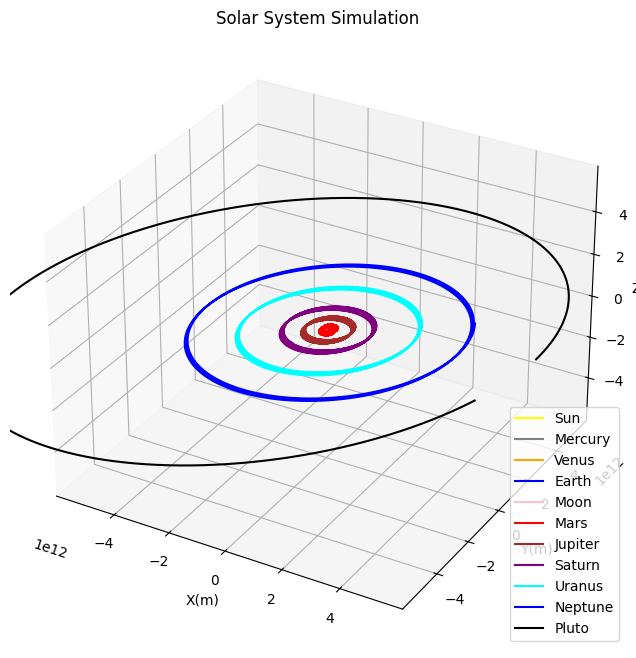

In [ ]:
solver.plot_sim("Solar System Simulation",zoom=2)

In [ ]:
ani = solver.animate_simulation_3d(title = "Solar System Animation",frame_skip=3000,fade_length=1)
HTML(ani.to_jshtml())

#Binary Star System#
This is a rough approximation of the Alpha Centauri binary. Proxima Centauri was excluded to make all bodies fit in one plot.

In [ ]:
M_siriusA=2.063*M_sun
M_siriusB=1.02*M_sun
pos_siriusA=np.array([-10*AU,0,0])
pos_siriusB=np.array([10*AU,0,0])
v_siriusA=np.array([0,2500,1000])
v_siriusB=np.array([0,-2500,1000])
R_siriusA=10
R_siriusB=10

binary_star=Solver(sec_hour*2)
binary_star.add_body(pos_siriusA,v_siriusA,M_siriusA,R_siriusA,"Sirius A","blue")
binary_star.add_body(pos_siriusB,v_siriusB,M_siriusB,R_siriusB,"Sirius B","red")
arr = binary_star.run_sim(sec_year*120)


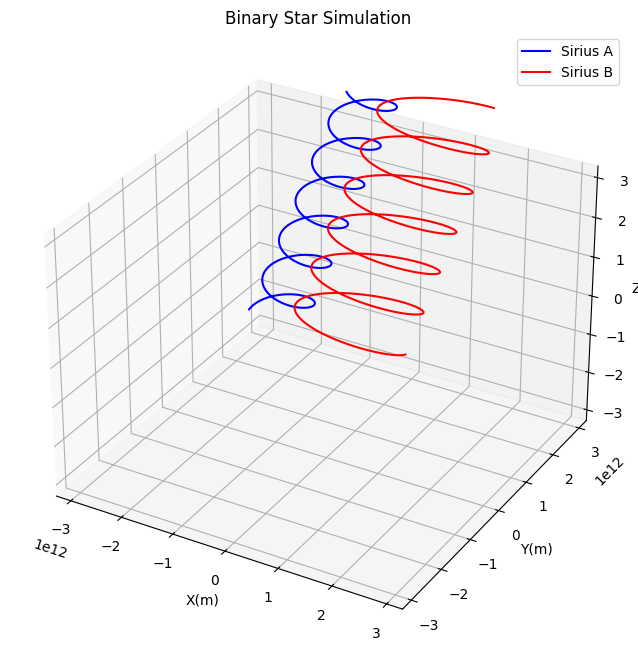

In [ ]:
binary_star.plot_sim("Binary Star Simulation",zoom=1.2)

In [ ]:
ani = binary_star.animate_simulation_3d(title = "Binary Star Animation",frame_skip=(2500))
HTML(ani.to_jshtml())

#3 Body Problem#
3 objects with varying Earth-scale mass and negligible radius are placed in an isoceles triangle with some intial velocities that were tweaked to produce interesting interactions. This resulted in chaotic motion. These interactions are impossible to solve in closed form; numerical methods such as Runge-Kutta are used to numerically predict motion.

In [ ]:
three_body2 = Solver(.1)
three_body2.add_body(np.array([0,3e6-6e6,1e6]), np.array([0,0,500]), M_earth*7, 0, "1", color='red')
three_body2.add_body(np.array([5e6, 3e6, 0]), np.array([0, -500, 0]),M_earth*15, 0, "2", color='blue')
three_body2.add_body(np.array([-5e6, 3e6, 0]), np.array([0, 500, -100]),8* M_earth,0, "3", color='green')
ARR=three_body2.run_sim(60 *sec_minute)


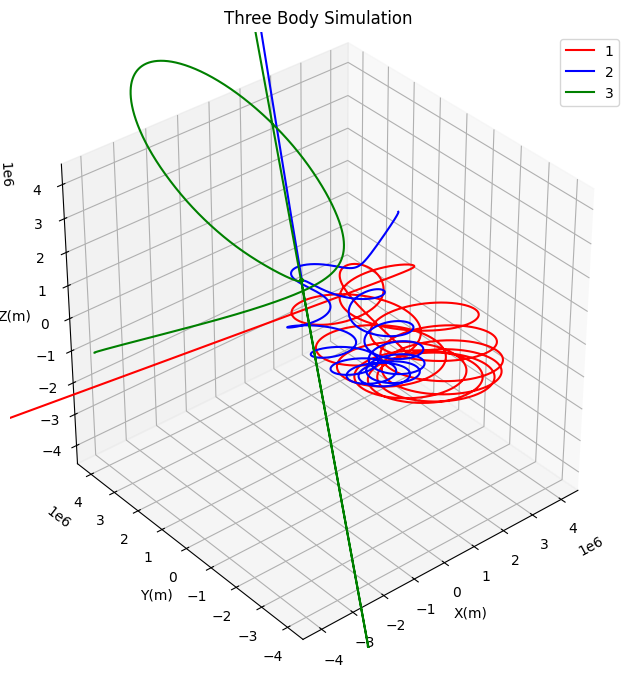

In [ ]:
three_body2.plot_sim("Three Body Simulation",zoom=200,camera=[35,230])

In [ ]:
ani = three_body2.animate_simulation_3d(title = "Three Body Animation",frame_skip=100,fade_length=30,zoom=200,camera=[35,230])
HTML(ani.to_jshtml())

#3 Body Problem with Elastic Collisions#
3 objects with $\frac{M_{\odot}}{50}$ and $R_{\odot}$ are placed at rest in a 3-4-5 right triangle with units of $AU/2$. This resulted in chaotic oscillating collisions, which we didn't expect to happen as much as it did. This arrangement tends to eject one body after some time, which we've found often happens in 3-body arrangements. It's somewhat difficult to find initial conditions that don't result in ejection of one or more bodies.

In [ ]:
three_body = Solver(sec_hour)
three_body.add_body(np.zeros(3), np.zeros(3), M_sun/50, R_sun, "1", color='red')
three_body.add_body(np.array([0, 3*AU/2, 0]), np.array([0, 0, 0]), M_sun/50, R_sun, "2", color='blue')
three_body.add_body(np.array([4*AU/2,0, 0]), np.array([0, 0, 0]), M_sun/50, R_sun, "3", color='green')

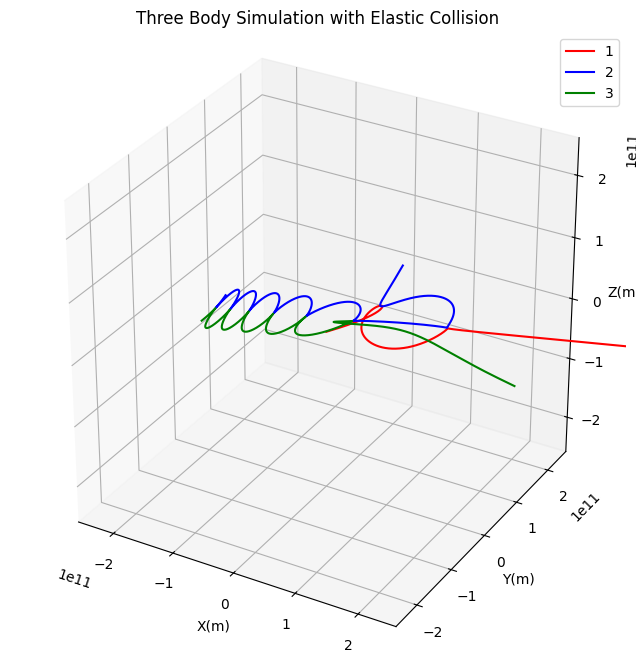

In [ ]:
arr = three_body.run_sim(sec_year*10)
three_body.plot_sim("Three Body Simulation with Elastic Collision",zoom=2.6)

In [ ]:
arr=three_body.run_sim(sec_year*100)

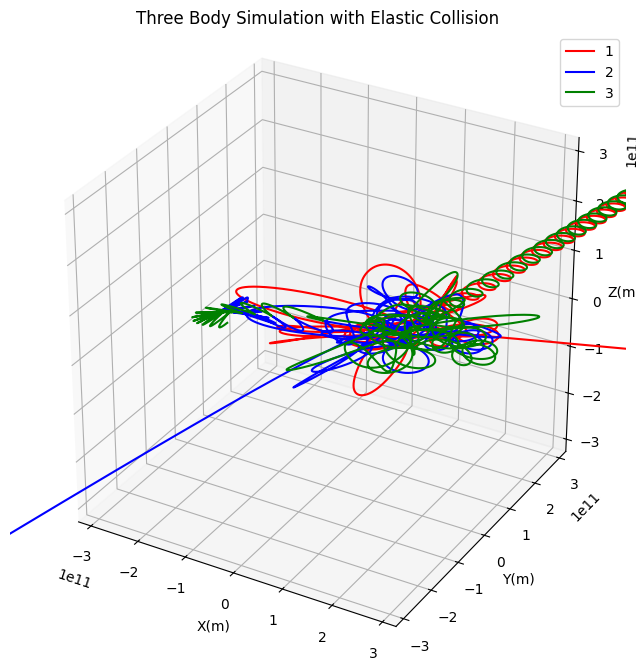

In [ ]:
three_body.plot_sim("Three Body Simulation with Elastic Collision",zoom=6)

In [ ]:
ani= three_body.animate_simulation_3d(title = "Three Body + Elastic Collisions Animation",fade_length=30,frame_skip=3000,zoom=6)
HTML(ani.to_jshtml())

#Head-on Collision#

Two Earths are launched towards each other with some orbital and z-velocity, causing periodic elastic collision.

In [ ]:
collider = Solver(60)
collider.add_body(np.array([0,0,0]), np.array([100,50,300]), M_earth, R_earth, "1", color='red')
collider.add_body(np.array([R_earth*20, 0, 0]), np.array([-100,-50,300]), M_earth, R_earth, "2", color='blue')
arr=collider.run_sim(sec_hour*700)

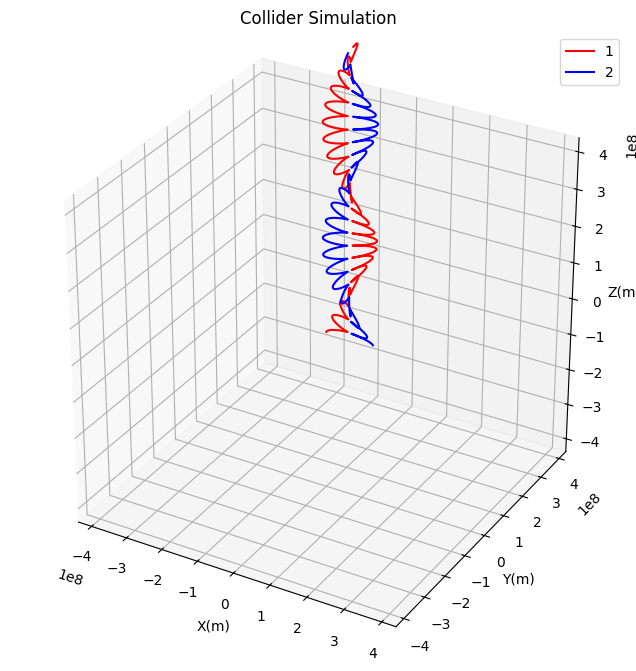

In [ ]:
collider.plot_sim("Collider Simulation",zoom=1.8)

In [ ]:
ani = collider.animate_simulation_3d(title = "Collider Animation",zoom=2,frame_skip=500)
HTML(ani.to_jshtml())


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/PHYS 246 Final Project"

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/PHYS 246 Final Project' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: 